# 05. Using a Trajectory instead of HOOMD simulation

In this notebook we show how to use an existing trajectory, possible from another simulation engine, to do computations. Reading is done via `MDAnalysis`, which is required to run these examples.

In [1]:
import hoomd
import hoomd.htf as htf
import tensorflow as tf
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
# disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Building our Model

We demonstrate two types of computation. The first is to compute a potential energy function from the trajectory. This could then be trained by force matching (not shown). The second is that we compute RDFs from the trajectory.

In [2]:
class TrajModel(htf.SimModel):
    def setup(self):
        self.avg_chrdf = tf.keras.metrics.MeanTensor()
        self.avg_ohrdf = tf.keras.metrics.MeanTensor()
    def compute(self, nlist, positions):                
        # pairwise energy. Double count -> divide by 2
        inv_r6 = htf.nlist_rinv(nlist)**6
        p_energy = 4.0 / 2.0 * (inv_r6 * inv_r6 - inv_r6)
        # sum over pairwise energy
        energy = tf.reduce_sum(p_energy, axis=1)
        # get forces
        forces = htf.compute_nlist_forces(nlist, energy)
        
        # now get RDF
        # For reference, type indices in this case are: {C:0, H:1, N:2, O:3} 
        # compute C-H RDF
        chrdf = htf.compute_rdf(
            nlist, [0, 15], positions[:, 3], 
            nbins=20, type_i=0, type_j=1)
        # compute O-H RDF
        ohrdf = htf.compute_rdf(
            nlist,[0, 15],  positions[:, 3], 
            nbins=20, type_i=3, type_j=1)
        # average the RDFs
        self.avg_chrdf.update_state(chrdf)
        self.avg_ohrdf.update_state(ohrdf)
        return forces
model = TrajModel(256)

## Run from trajectory

We load the trajectory with `MDAnalysis` and then call the `iter_from_trajectory` command. It runs over the trajectory computing the graph and constructs neighborlists according to the r_cut. 

In [3]:
universe = mda.Universe('test_topol.pdb', 'test_traj.trr')
for inputs, ts in htf.iter_from_trajectory(256, universe, r_cut=25):
    result = model(inputs)

## Analysis

Now we plot our RDFs. Note that the trajectory is very short to save on space in the repo, so the RDFs are under-sampled. Also, HOOMD-TF makes no attempt at normalizing the RDF

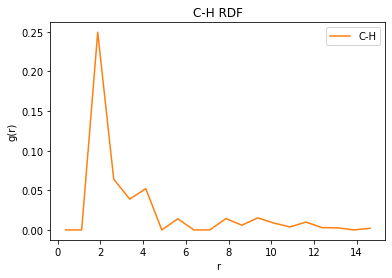

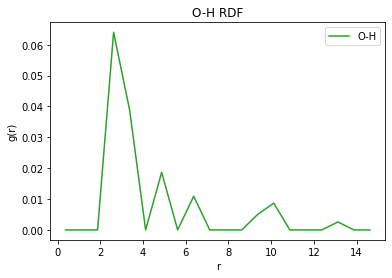

In [4]:
# Plot C-H rdf
chrdf = model.avg_chrdf.result().numpy()
plt.figure()
plt.plot(chrdf[1, :], chrdf[0, :], label='C-H', color='C1')
plt.title(r'C-H RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()

# Plot O-H rdf
ohrdf = model.avg_ohrdf.result().numpy()

plt.figure()
plt.plot(ohrdf[1, :], ohrdf[0, :], label='O-H', color='C2')
plt.title(r'O-H RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()